# Phonopy in Python

Maintainer: Zekun Lou

This notebook provides a straightforward guide to using `phonopy` in Python scripts with graphite as example.

It serves as a starting point for those who want to avoid the black box of `phonopy` shell commands, and prefer to integrate `phonopy` into their own Python scripts for customizing workflows.


Although this document is fairly detailed, **the core Python code is concise** (no more than some `import`s and simple function calls). The additional content is included to enhance clarity and provide better explanations. You can copy and modify the code snippets to fit your specific needs.

The **workflow** is as follows:

1. Converge the k-grid for the primitive cell and relax the primitive cell by `FHI-aims`.
1. Generate supercells with displacements using `phonopy`.
1. Perform force calculations for each supercell using `FHI-aims`.
1. Extract forces and construct force constants by `phonopy`.
    - This serves as a milestone for post-processing.
1. Compute the phonon band structure using `phonopy`.

The project’s **file structure** is as follows:

```text
${PROJECT_ROOT}
├── fd_runs
│   ├── sc_3  # for example, supercell size 3x3x3
│   │   ├── aims_runs
│   │   │   └── {0..${n}}  # directories for each run
│   │   ├── geoms_disp
│   │   │   └── {0..${n}}.xyz
│   │   ├── logs
│   │   ├── control.force.in  # for FHI-aims force calculation
│   │   ├── force_constants.h5  # force_constants hdf5 file saved by phonopy
│   │   ├── phono_bandstr.meV.png  # phonon band structure plot
│   │   └── phonopy_params.yaml  # phonopy meta-settings for this calculation
│   └── sc_${sc}  # other supercell sizes
├── relax_cell  # dir for cell relaxation calculations
│   └── relaxed.xyz  # the relaxed cell
└── phonopy_in_python.ipynb  # this file
```


In [1]:
""" change dir to ensure the file relative paths """
import os

PROJECT_ROOT = os.getcwd()
assert PROJECT_ROOT.endswith("docs/source")
PROJECT_ROOT = os.path.join(PROJECT_ROOT, "phonopy_simple")
print(PROJECT_ROOT)

/home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple


In [2]:
import matplotlib.pyplot as plt
import numpy
from ase.atoms import Atoms as aseAtoms
from ase.io import read, write

from phonopy import Phonopy
from phonopy.cui.load import load as load_phonopy
from phonopy.file_IO import read_force_constants_hdf5, write_force_constants_to_hdf5
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from phonopy.structure.atoms import PhonopyAtoms

In [3]:
""" prepare useful functions """

def atoms_ase2ph(atoms: aseAtoms):
    if not numpy.all(atoms.get_pbc()):
        print("WARNING: for PhonopyAtoms the pbc must be T T T. Set to T T T.")
    return PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell().array,
        positions=atoms.get_positions(),
    )

def atoms_ph2ase(atoms: PhonopyAtoms):
    return aseAtoms(
        symbols=atoms.symbols,
        cell=atoms.cell,
        positions=atoms.positions,
        pbc=True,
    )

In [ ]:
""" prepare parameters """

supercell = 3
work_dpath = f"{PROJECT_ROOT}/fd_runs/sc_{supercell}"
displacement = 1e-2
xyz_eq_fpath = f"{PROJECT_ROOT}/relax_cell/relaxed.xyz"

""" prepare directories and files """

geoms_dpath = f"{work_dpath}/geoms_disp"
aims_dpath = f"{work_dpath}/aims_runs"
logs_dpath = f"{work_dpath}/logs"
phonpy_params_fpath = f"{work_dpath}/phonopy_params.yaml"
force_constants_fpath = f"{work_dpath}/force_constants.h5"
[os.makedirs(dpath, exist_ok=True) for dpath in (geoms_dpath, aims_dpath, logs_dpath)]
atoms_prim = read(xyz_eq_fpath)

""" better load from phonopy_params.yaml for reproducibility """

if os.path.exists(phonpy_params_fpath):
    phonon = load_phonopy(phonpy_params_fpath)
    print(f"Loaded phonopy parameters from {phonpy_params_fpath}")
else:
    phonon = Phonopy(
        unitcell=atoms_ase2ph(atoms_prim),
        supercell_matrix=numpy.eye(3, dtype=int) * supercell,
    )
    phonon.generate_displacements(distance=displacement)
    phonon.save(phonpy_params_fpath)

""" write the displaced supercells for FHI-aims calculation """
for i, this_sc in enumerate(phonon.supercells_with_displacements):
    write(f"{geoms_dpath}/{i}.xyz", atoms_ph2ase(this_sc))
    os.makedirs(f"{aims_dpath}/{i}", exist_ok=True)
    write(f"{aims_dpath}/{i}/geometry.in", atoms_ph2ase(this_sc), format="aims")

Loaded phonopy parameters from /home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple/fd_runs/sc_3/phonopy_params.yaml


In [ ]:
""" load force constants and save it h5, because it could be slow, especially for large supercells and repeated calculations """

if os.path.exists(force_constants_fpath):
    phonon.force_constants = read_force_constants_hdf5(force_constants_fpath)
    print(f"Loaded force constants from {force_constants_fpath}")
else:
    force_sets = numpy.array([
        read(
            os.path.join(f"{aims_dpath}/{task_idx}/aims.out"),
            format="aims-output"
        ).get_forces()
        for task_idx in sorted(os.listdir(aims_dpath), key=lambda x: int(x))
    ])
    phonon.produce_force_constants(forces=force_sets)
    # we can generate compact force constants here
    # by setting calculate_full_force_constants=False
    write_force_constants_to_hdf5(
        phonon.get_force_constants(),
        filename=force_constants_fpath,
    )
print(f"{phonon.force_constants.shape=}")

Loaded force constants from /home/zekunlou/Projects/docs_howtos/docs/source/phonopy_simple/fd_runs/sc_3/force_constants.h5
phonon.force_constants.shape=(108, 108, 3, 3)


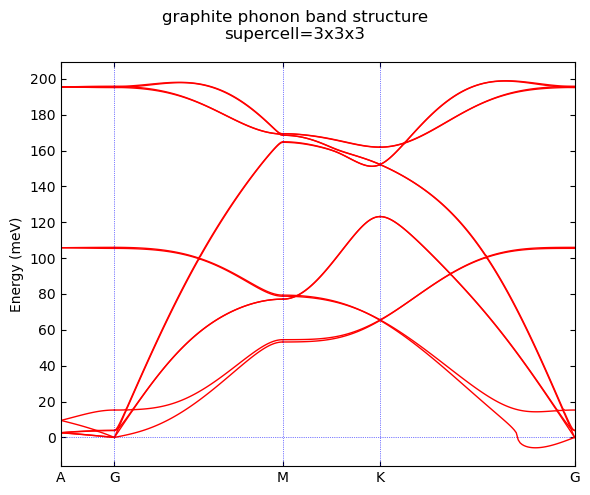

In [6]:
""" calculate phonon band structure """

special_points = {  # for hexagon cell with gamma = 60.0 deg
    "G": [0.0, 0.0, 0.0],
    "M": [1 / 2, 1 / 2, 0.0],
    "K": [1 / 3, 2 / 3, 0.0],
    "A": [0.0, 0.0, 1 / 2],
}

bz_labels = ["A", "G", "M", "K", "G"]
kpath = [[special_points[label] for label in bz_labels]]  # must be 2-level list
kpts, connections = get_band_qpoints_and_path_connections(kpath, npoints=101)

phonon.run_band_structure(kpts, path_connections=connections, labels=bz_labels)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
phonon._band_structure.plot([ax])  # a hack here, should be List[Axes]
xscale_factor = (
    max([numpy.max(fq) for fq in phonon._band_structure.frequencies])
    / phonon._band_structure.distances[-1][-1]
    * 1.5
)  # this can be found in phonopy src code
for d in phonon._band_structure.distances:
    ax.axvline(d[-1] * xscale_factor, color="b", linestyle=":", linewidth=0.5)

ax_unit = ["meV", "cm-1", "THz"][0]  # choose your preferred unit
if ax_unit == "meV":
    ax.set_ylabel("Energy (meV)")
    ax.set_ylim(ax.get_ylim())
    ax_yticks_in_meV = numpy.arange(0, 220, 20)
    ax.set_yticks(ax_yticks_in_meV / 4.1357, ax_yticks_in_meV)
elif ax_unit == "cm-1":
    ax_yticks_in_cm = numpy.arange(0, 1800, 200)
    ax.set_yticks(ax_yticks_in_cm / 4.1357 / 8.1, ax_yticks_in_cm)
    ax.set_ylabel("Frequency (cm$^{-1}$)")
elif ax_unit == "THz":
    ax.set_ylabel("Frequency (THz)")
else:
    raise ValueError(f"Unknown ax_unit: {ax_unit}")

fig.suptitle(
    f"graphite phonon band structure\nsupercell={supercell}x{supercell}x{supercell}"
)
fig.tight_layout()
fig = plt.gcf()
fig.savefig(f"{work_dpath}/phonon_bandstr.{ax_unit}.png", dpi=300, transparent=True)


The band structure will converge with supercell `5x5x5`, i.e. without imaginary frequencies. Its force constants matrix is too largee so we are using `3x3x3` as example here.

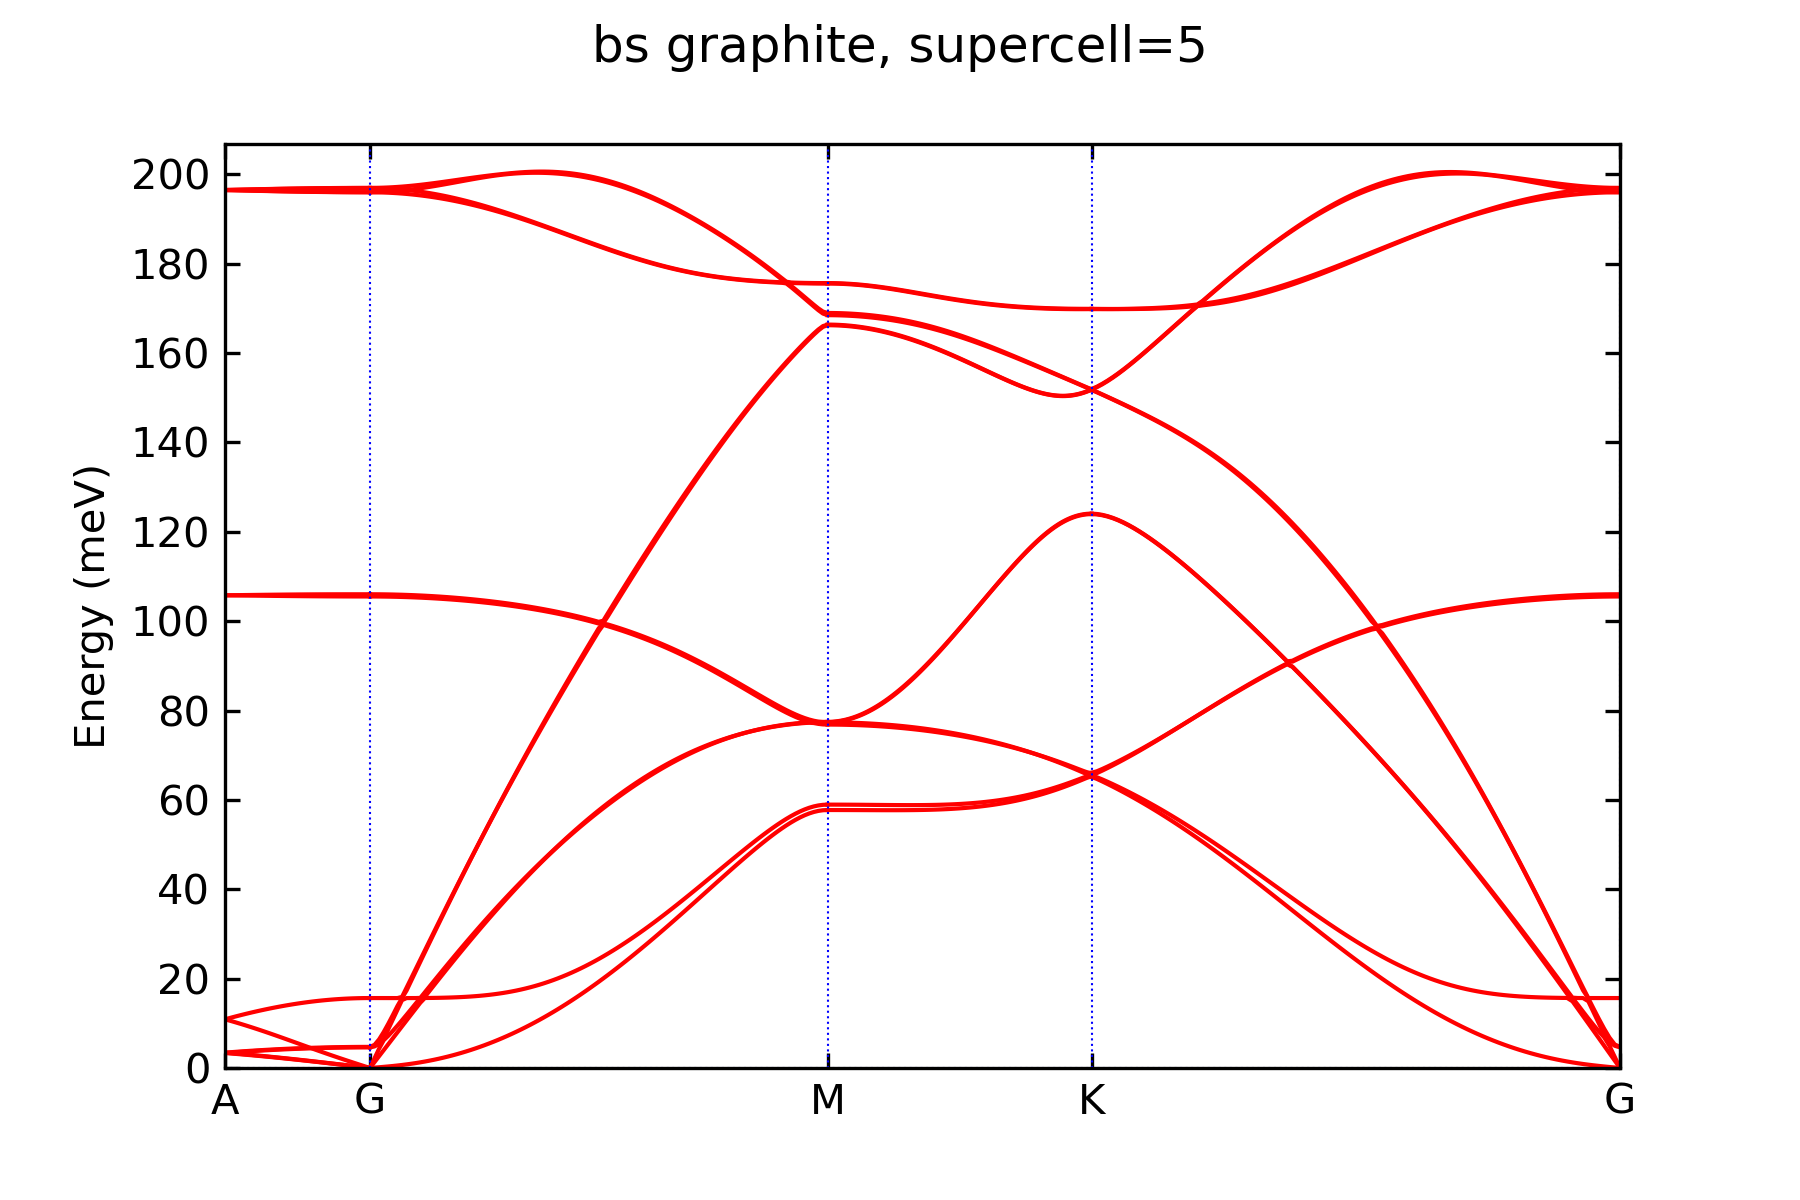

In [7]:
from PIL import Image

Image.open(f"{PROJECT_ROOT}/fd_runs/sc_5/ph_bandstr.meV.png")
